In [1]:
using Dates
using JuMP
using CSV
using DataFrames
using LinearAlgebra
using Distributions
using Statistics
using Dates
using Plots
ENV["COLUMNS"] = 200;
include("COVIDResourceAllocation.jl")
using .COVIDResourceAllocation

In [167]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
start_date = Date(2020, 3, 4)
end_date   = Date(2020, 5, 22)
date_range = start_date:end_date
T = (end_date - start_date).value + 1
travel_threshold_hours = 8.0

adj = adjacencies(states, level=:state, source=:google, threshold=travel_threshold_hours);

In [168]:
hospitalized_days = ceil(mean(Weibull(1.38,12.88)))
forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_active = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_admitted = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_discharged = forecast(
    states, start_date-Dates.Day(ceil(mean(Weibull(1.38,12.88)))), end_date-Dates.Day(ceil(mean(Weibull(1.38,12.88)))),
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
);

In [169]:
pct_nurses_available = 0.5
patients_per_nurse_covid = 2.5
nurse_hrs_per_week_covid = 36
#pct_beds_available = 0.25

#beds = n_beds(states, bed_type=:all, pct_beds_available=pct_beds_available)

N = length(states);

#forecast_discharged = hcat(forecast_discharged, zeros(Float32, N, T - hospitalized_days))

@show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
@show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

@show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;

nurses = n_nurses(states) * Float32(pct_nurses_available);

nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7 = 5.142857142857143
nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid = 4.666666666666666
nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid = 1.8666666666666665


## Shortage Plots

In [170]:
start_date = Date(2020, 3, 4)
end_date   = Date(2020, 5, 22)
date_range = start_date:end_date
T = (end_date - start_date).value + 1

hospitalized_days = ceil(mean(Weibull(1.38,12.88)))
forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_active = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_admitted = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_discharged = forecast(
    states, start_date-Dates.Day(ceil(mean(Weibull(1.38,12.88)))), end_date-Dates.Day(ceil(mean(Weibull(1.38,12.88)))),
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
);

In [171]:
L = 1.0 .- cdf.(Weibull(1.38,12.88), 0:T)

81-element Vector{Float64}:
 1.0
 0.9710300278409099
 0.9263405009076999
 0.8746875424718533
 0.8194350162364836
 0.7626519828327724
 0.7057674052988676
 0.6498110972163968
 0.5955327447487897
 0.5434722537661996
 ⋮
 2.1431350792133763e-5
 1.743114246888222e-5
 1.416230279649433e-5
 1.1494168196457544e-5
 9.31881560561898e-6
 7.5472224875250404e-6
 6.106052565901798e-6
 4.9349696477074545e-6
 3.984396320211303e-6

In [216]:
net_patients_per_day = [(
    forecast_initial[i]
	- forecast_discharged[i,t]
	+ sum(L[t-t₁+1]forecast_admitted[i,t₁] for t₁ in 1:t)
	) for i in 1:N, t in 1:T
]
demand = net_patients_per_day*nurse_days_per_patient_day_covid
net_shortage = max.(zeros(11,T),demand .- nurses);

In [219]:
df = DataFrame(permutedims(net_shortage), :auto)

# Add column names
columns = ["Column_$i" for i in 1:length(states)]
rename!(df, states)

show(df, allcols=true)

using Statistics
describe(df)
using CSV
CSV.write("../data output/DSstateHistoricalShortage.csv",describe(df))

80×11 DataFrame
 Row │ CT       DE       MA        MD       ME       NH       NJ        NY         PA        RI       VT      
     │ Float64  Float64  Float64   Float64  Float64  Float64  Float64   Float64    Float64   Float64  Float64 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │    0.0       0.0    0.0        0.0       0.0      0.0      0.0      0.0        0.0      0.0        0.0
   2 │    0.0       0.0    0.0        0.0       0.0      0.0      0.0      0.0        0.0      0.0        0.0
   3 │    0.0       0.0    0.0        0.0       0.0      0.0      0.0      0.0        0.0      0.0        0.0
   4 │    0.0       0.0    0.0        0.0       0.0      0.0      0.0      0.0        0.0      0.0        0.0
   5 │    0.0       0.0    0.0        0.0       0.0      0.0      0.0      0.0        0.0      0.0        0.0
   6 │    0.0       0.0    0.0        0.0       0.0      0.0      0.0      0.0        0.0      0.0   

"../data output/DSstateHistoricalShortage.csv"

In [191]:
net_shortage_p_hosp = vec(sum(net_shortage, dims=1))

80-element Vector{Float64}:
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     ⋮
 21526.612267733395
 19929.742291096278
 18452.722117220987
 17051.039783795055
 15668.958667234727
 14302.708337188238
 12997.440245907143
 11734.426480885384
 10673.012547730043

In [204]:
net_shortage = DataFrame(date = date_range, shortage = net_shortage_p_hosp)

Row,date,shortage
,Date,Float64
1,2020-03-04,0.0
2,2020-03-05,0.0
3,2020-03-06,0.0
4,2020-03-07,0.0
5,2020-03-08,0.0
6,2020-03-09,0.0
7,2020-03-10,0.0
8,2020-03-11,0.0
9,2020-03-12,0.0


In [215]:
using DataFrames

# Summary statistics
length_val = 80
missing_count = 0
mean_val = 24496.972698
std_deviation = 20666.531589
minimum_val = 0.000000
first_quartile = 0.000000
median_val = 23764.272378
third_quartile = 44801.795556
maximum_val = 54114.532261
type_val = "Float64"

# Create DataFrame
df_summary = DataFrame(
    Statistic = ["Length", "Missing Count", "Mean", "Std. Deviation", "Minimum", "1st Quartile", "Median", "3rd Quartile", "Maximum"],
    Value = [length_val, missing_count, mean_val, std_deviation, minimum_val, first_quartile, median_val, third_quartile, maximum_val]
)

# Show DataFrame
show(df_summary, allrows=true)

using CSV
CSV.write("../data output/DSHistoricalShortage.csv",df_summary)

9×2 DataFrame
 Row │ Statistic       Value   
     │ String          Float64 
─────┼─────────────────────────
   1 │ Length             80.0
   2 │ Missing Count       0.0
   3 │ Mean            24497.0
   4 │ Std. Deviation  20666.5
   5 │ Minimum             0.0
   6 │ 1st Quartile        0.0
   7 │ Median          23764.3
   8 │ 3rd Quartile    44801.8
   9 │ Maximum         54114.5

"../data output/DSHistoricalShortage.csv"

In [175]:
using CSV
CSV.write("../data output/NoTransferShortage304-522.csv",net_shortage)

"../data output/NoTransferShortage304-522.csv"

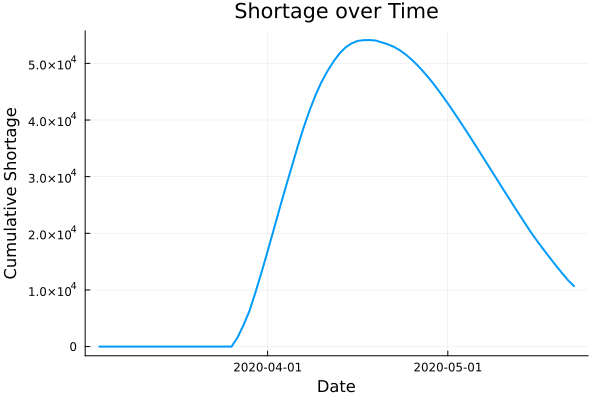

In [193]:
gr()
plot(date_range, net_shortage_p_hosp,
     xlabel = "Date",
     ylabel = "Cumulative Shortage",
     title = "Shortage over Time",
     legend = false,
     linewidth = 2,fmt=:png) 
#savefig(joinpath("../figures", "Historical_shortage_plot224-524.png"))    

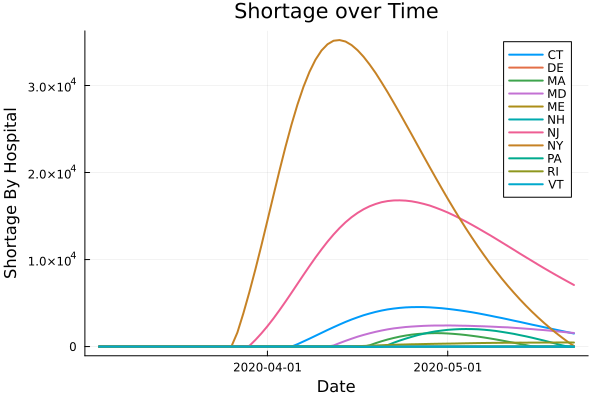

In [196]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)
# start_date = Date(2020, 3, 30)
# end_date   = Date(2020, 6, 30)
# date_range = start_date:end_date
# T = (end_date - start_date).value + 1

plot(date_range, [vec(net_shortage[i,1:T]) for i in 1:size(net_shortage[:,1:T])[1]],
     xlabel = "Date",
     ylabel = "Shortage By Hospital",
     title = "Shortage over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
#savefig(joinpath("../figures", "Historical_shortage_plot_states304-522.png"))    